In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
import warnings
import seaborn

from scipy.special import expit as logistic

warnings.simplefilter(action="ignore", category=FutureWarning)
az.style.use("arviz-darkgrid")

# Data

3 outcome variables, 2 predictors (one continuous, one binary)

Repeated measures by participants (one participant saw a specific manipluation multiple times)
Repeated measures by items (item 1 was seen by every participant)

So one would expect varying intercepts and slopes by participant and item

In [35]:
s2data = pd.read_csv("S2data.csv")
s2data.head()

,Unnamed: 0,Participant,ItemID,Response,Scenario,Item,Evident,S
0,0,Survey1_1,Item1b,believe,Briefing,1,0,0
1,1,Survey1_1,Item2a,believe,Briefing,2,100,0
2,2,Survey1_1,Item3b,believe,Briefing,3,86,0
3,3,Survey1_1,Item4a,believe,Briefing,4,100,0
4,4,Survey1_1,Item5b,believe,Briefing,5,15,0


In [36]:
# standardise predictor 1
x_E = s2data['Evident']
x_E = x_E.values

s2data['Es'] = (x_E - x_E.mean(axis=0))/ x_E.std(axis=0)


s2data.head()

,Unnamed: 0,Participant,ItemID,Response,Scenario,Item,Evident,S,Es
0,0,Survey1_1,Item1b,believe,Briefing,1,0,0,-2.688224
1,1,Survey1_1,Item2a,believe,Briefing,2,100,0,1.031726
2,2,Survey1_1,Item3b,believe,Briefing,3,86,0,0.510933
3,3,Survey1_1,Item4a,believe,Briefing,4,100,0,1.031726
4,4,Survey1_1,Item5b,believe,Briefing,5,15,0,-2.130231


In [43]:
# prepare outcome
y_r = pd.Categorical(s2data["Response"]).codes
y_r

array([0, 0, 0, ..., 0, 2, 1], dtype=int8)

In [38]:
# prepare predictor Evidentiality, continous predictor (not standardised: [0,100])
#x_n = s1data.columns[21]
X_Es = s2data['Es'].values
X_Es = X_Es.reshape(1660, 1)
X_Es

array([[-2.68822357],
       [ 1.03172568],
       [ 0.51093279],
       ...,
       [-0.45625402],
       [-1.94423372],
       [ 0.65973076]])

In [39]:
# prepare predictor Scenario, binary predictor (0/1)
X_S = s2data['S'].values
X_S = X_S.reshape(1660, 1)
X_S 

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [13]:
X_Es.shape, X_S.shape, y_r.shape, np.unique(y_r)

((1660, 1), (1660, 1), (1660,), array([0, 1, 2], dtype=int8))

In [40]:
# if X_Es and X_S were part of one (X_all) for tt.dot(X_all, beta)
x_n = s2data.columns[7:9]
Xall = s2data[x_n].values
Xall = Xall.reshape(1660, 2)
#Xall[:,1:2]
Xall

array([[ 0.        , -2.68822357],
       [ 0.        ,  1.03172568],
       [ 0.        ,  0.51093279],
       ...,
       [ 0.        , -0.45625402],
       [ 0.        , -1.94423372],
       [ 0.        ,  0.65973076]])

In [41]:
# participants
s2data['Pcode'] = pd.Categorical(s2data["Participant"]).codes
subject_names = s2data.Participant.unique()
sub_idx = s2data.Pcode.values

n_sub = len(s2data.Participant.unique())

sub_idx, n_sub

(array([ 0,  0,  0, ..., 82, 82, 82], dtype=int8), 83)

In [42]:
# items
s2data['Icode'] = pd.Categorical(s2data["Item"]).codes
item_idx = s2data.Icode.values

n_item = len(s2data.Icode.unique())

item_idx, n_item

(array([ 0,  1,  2, ..., 17, 18, 19], dtype=int8), 20)

# Simple Model

In [44]:
with pm.Model() as model1:
    
    intercept = pm.Normal('intercept', mu=0, sd=1, shape=2)
    intercept_f = tt.concatenate([[0], intercept])
                                  
    beta = pm.Normal('beta', mu=0, sd=.5, shape=(2, 2))
    beta_f = tt.concatenate([np.zeros((2, 1)), beta], axis=1)  
    
    X = pm.Data("X", Xall)
    mu = intercept_f + pm.math.dot(Xall, beta_f)
    likelihood = pm.Deterministic('likelihood', tt.nnet.softmax(mu))

    y1 = pm.Categorical('y1', p=likelihood, observed=y_r)

    trace1 = pm.sample(1000, tune=2000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, intercept]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 38 seconds.


In [45]:
az.summary(trace1, round_to=2, var_names=['intercept', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept[0],-0.52,0.08,-0.68,-0.36,0.0,0.0,1659.22,1643.41,1668.58,1333.11,1.0
intercept[1],-1.57,0.12,-1.79,-1.35,0.0,0.0,1765.30,1763.77,1764.64,1511.29,1.0
"beta[0,0]",0.29,0.11,0.08,0.50,0.0,0.0,1472.93,1381.48,1485.63,1458.69,1.0
"beta[0,1]",-0.10,0.16,-0.40,0.20,0.0,0.0,1756.24,1325.96,1783.32,1456.94,1.0
"beta[1,0]",1.21,0.08,1.08,1.36,0.0,0.0,1802.71,1789.31,1810.38,1434.43,1.0
"beta[1,1]",-0.05,0.08,-0.19,0.10,0.0,0.0,1799.19,1176.33,1797.41,1389.54,1.0


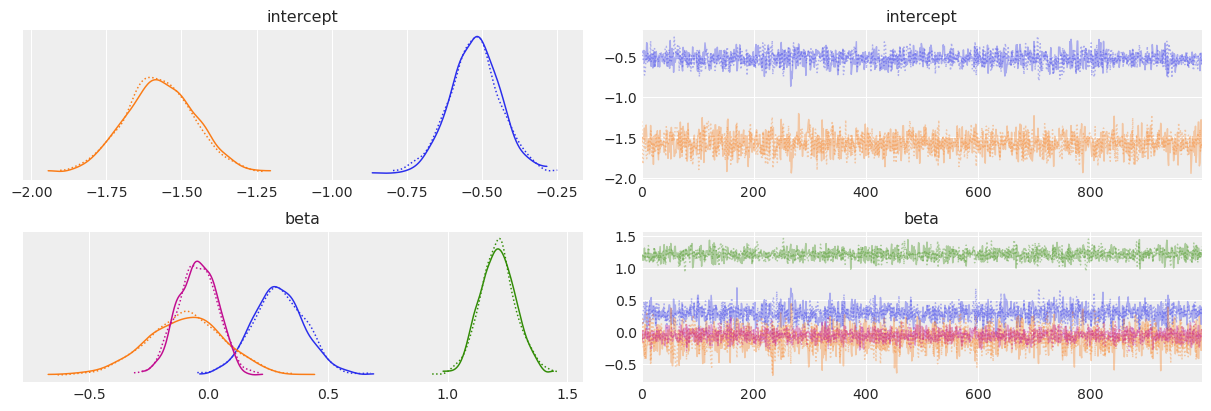

In [46]:
pm.traceplot(trace1,
             var_names=['intercept', 'beta']);

# Hierarchical Model
accounting for subject differences

In [47]:
with pm.Model() as hier_mod:
    mu_a = pm.Normal('mu_a', mu=0.0, sd=1.0, shape=2)
    sigma_a = pm.HalfNormal('sigma_a', 1, shape=2)
    mu_b1 = pm.Normal('mu_b1', mu=0., sd=.5, shape=(1,2))
    #sigma_b1 = pm.HalfNormal('sigma_b1', .5, shape=(1,2))
    mu_b2 = pm.Normal('mu_b2', mu=0., sd=.5, shape=(1,2))
    #sigma_b2 = pm.HalfNormal('sigma_b2', 5., shape=(1,2))
    
    intercept = pm.Normal('intercept', mu=mu_a, sd=sigma_a, shape=(n_sub, 2))
    intercept_f = tt.concatenate([np.zeros((n_sub, 1)), intercept], axis=1)
                                  
    beta_1 = pm.Normal('beta_1', mu=mu_b1, sd=.5, shape=(n_sub, 2))
    beta_1f = tt.concatenate([np.zeros((n_sub, 1)), beta_1], axis=1)  
    
    beta_2 = pm.Normal('beta_2', mu=mu_b2, sd=.5, shape=(n_sub, 2))
    beta_2f = tt.concatenate([np.zeros((n_sub, 1)), beta_2], axis=1)                            

    #X = pm.Data("X", X_all)
    mu = intercept_f[sub_idx] + beta_1f[sub_idx] * X_Es + beta_2f[sub_idx] * X_S
    likelihood = pm.Deterministic('likelihood', tt.nnet.softmax(mu))

    y1 = pm.Categorical('y1', p=likelihood, observed=y_r)

    trace_hier = pm.sample(1000, tune=2000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_2, beta_1, intercept, mu_b2, mu_b1, sigma_a, mu_a]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 144 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [48]:
az.summary(trace_hier, round_to=2, var_names=['mu_a', 'mu_b1', 'mu_b2'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a[0],-0.70,0.14,-0.93,-0.41,0.00,0.00,894.51,890.84,892.00,1201.88,1.0
mu_a[1],-2.56,0.27,-3.12,-2.09,0.01,0.01,857.12,848.01,864.97,1320.12,1.0
"mu_b1[0,0]",1.59,0.11,1.39,1.81,0.00,0.00,949.03,939.91,954.09,1515.28,1.0
"mu_b1[0,1]",-0.02,0.13,-0.27,0.21,0.00,0.00,860.93,860.93,858.54,1113.18,1.0
"mu_b2[0,0]",0.33,0.14,0.07,0.59,0.01,0.00,500.25,500.25,499.87,919.49,1.0
"mu_b2[0,1]",-0.20,0.19,-0.58,0.14,0.01,0.01,355.26,355.26,357.40,555.11,1.0


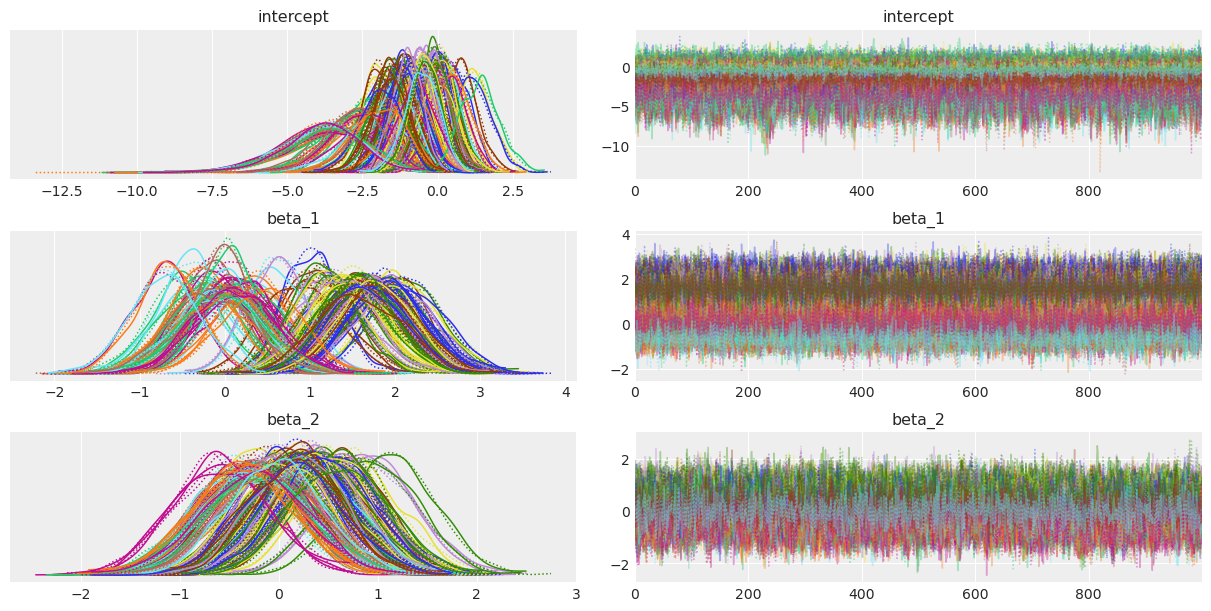

In [49]:
pm.traceplot(trace_hier,
             var_names=['intercept', 'beta_1', 'beta_2']);

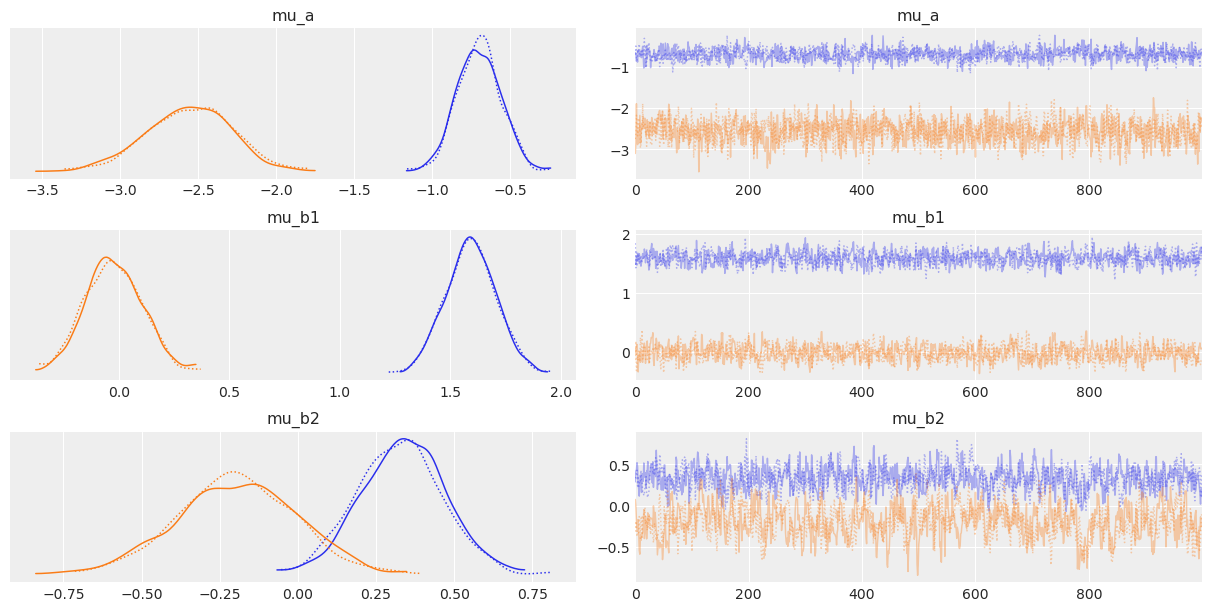

In [50]:
pm.traceplot(trace_hier,
             var_names=['mu_a', 'mu_b1', 'mu_b2']);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A6EBB7C0F0>],
      dtype=object)

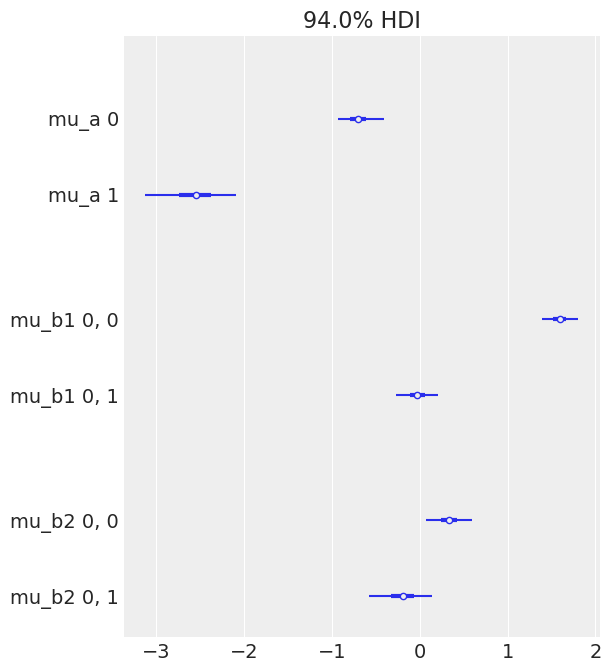

In [51]:
pm.forestplot(trace_hier, var_names=['mu_a', 'mu_b1', 'mu_b2'], combined=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A6EC180550>,
      dtype=object)

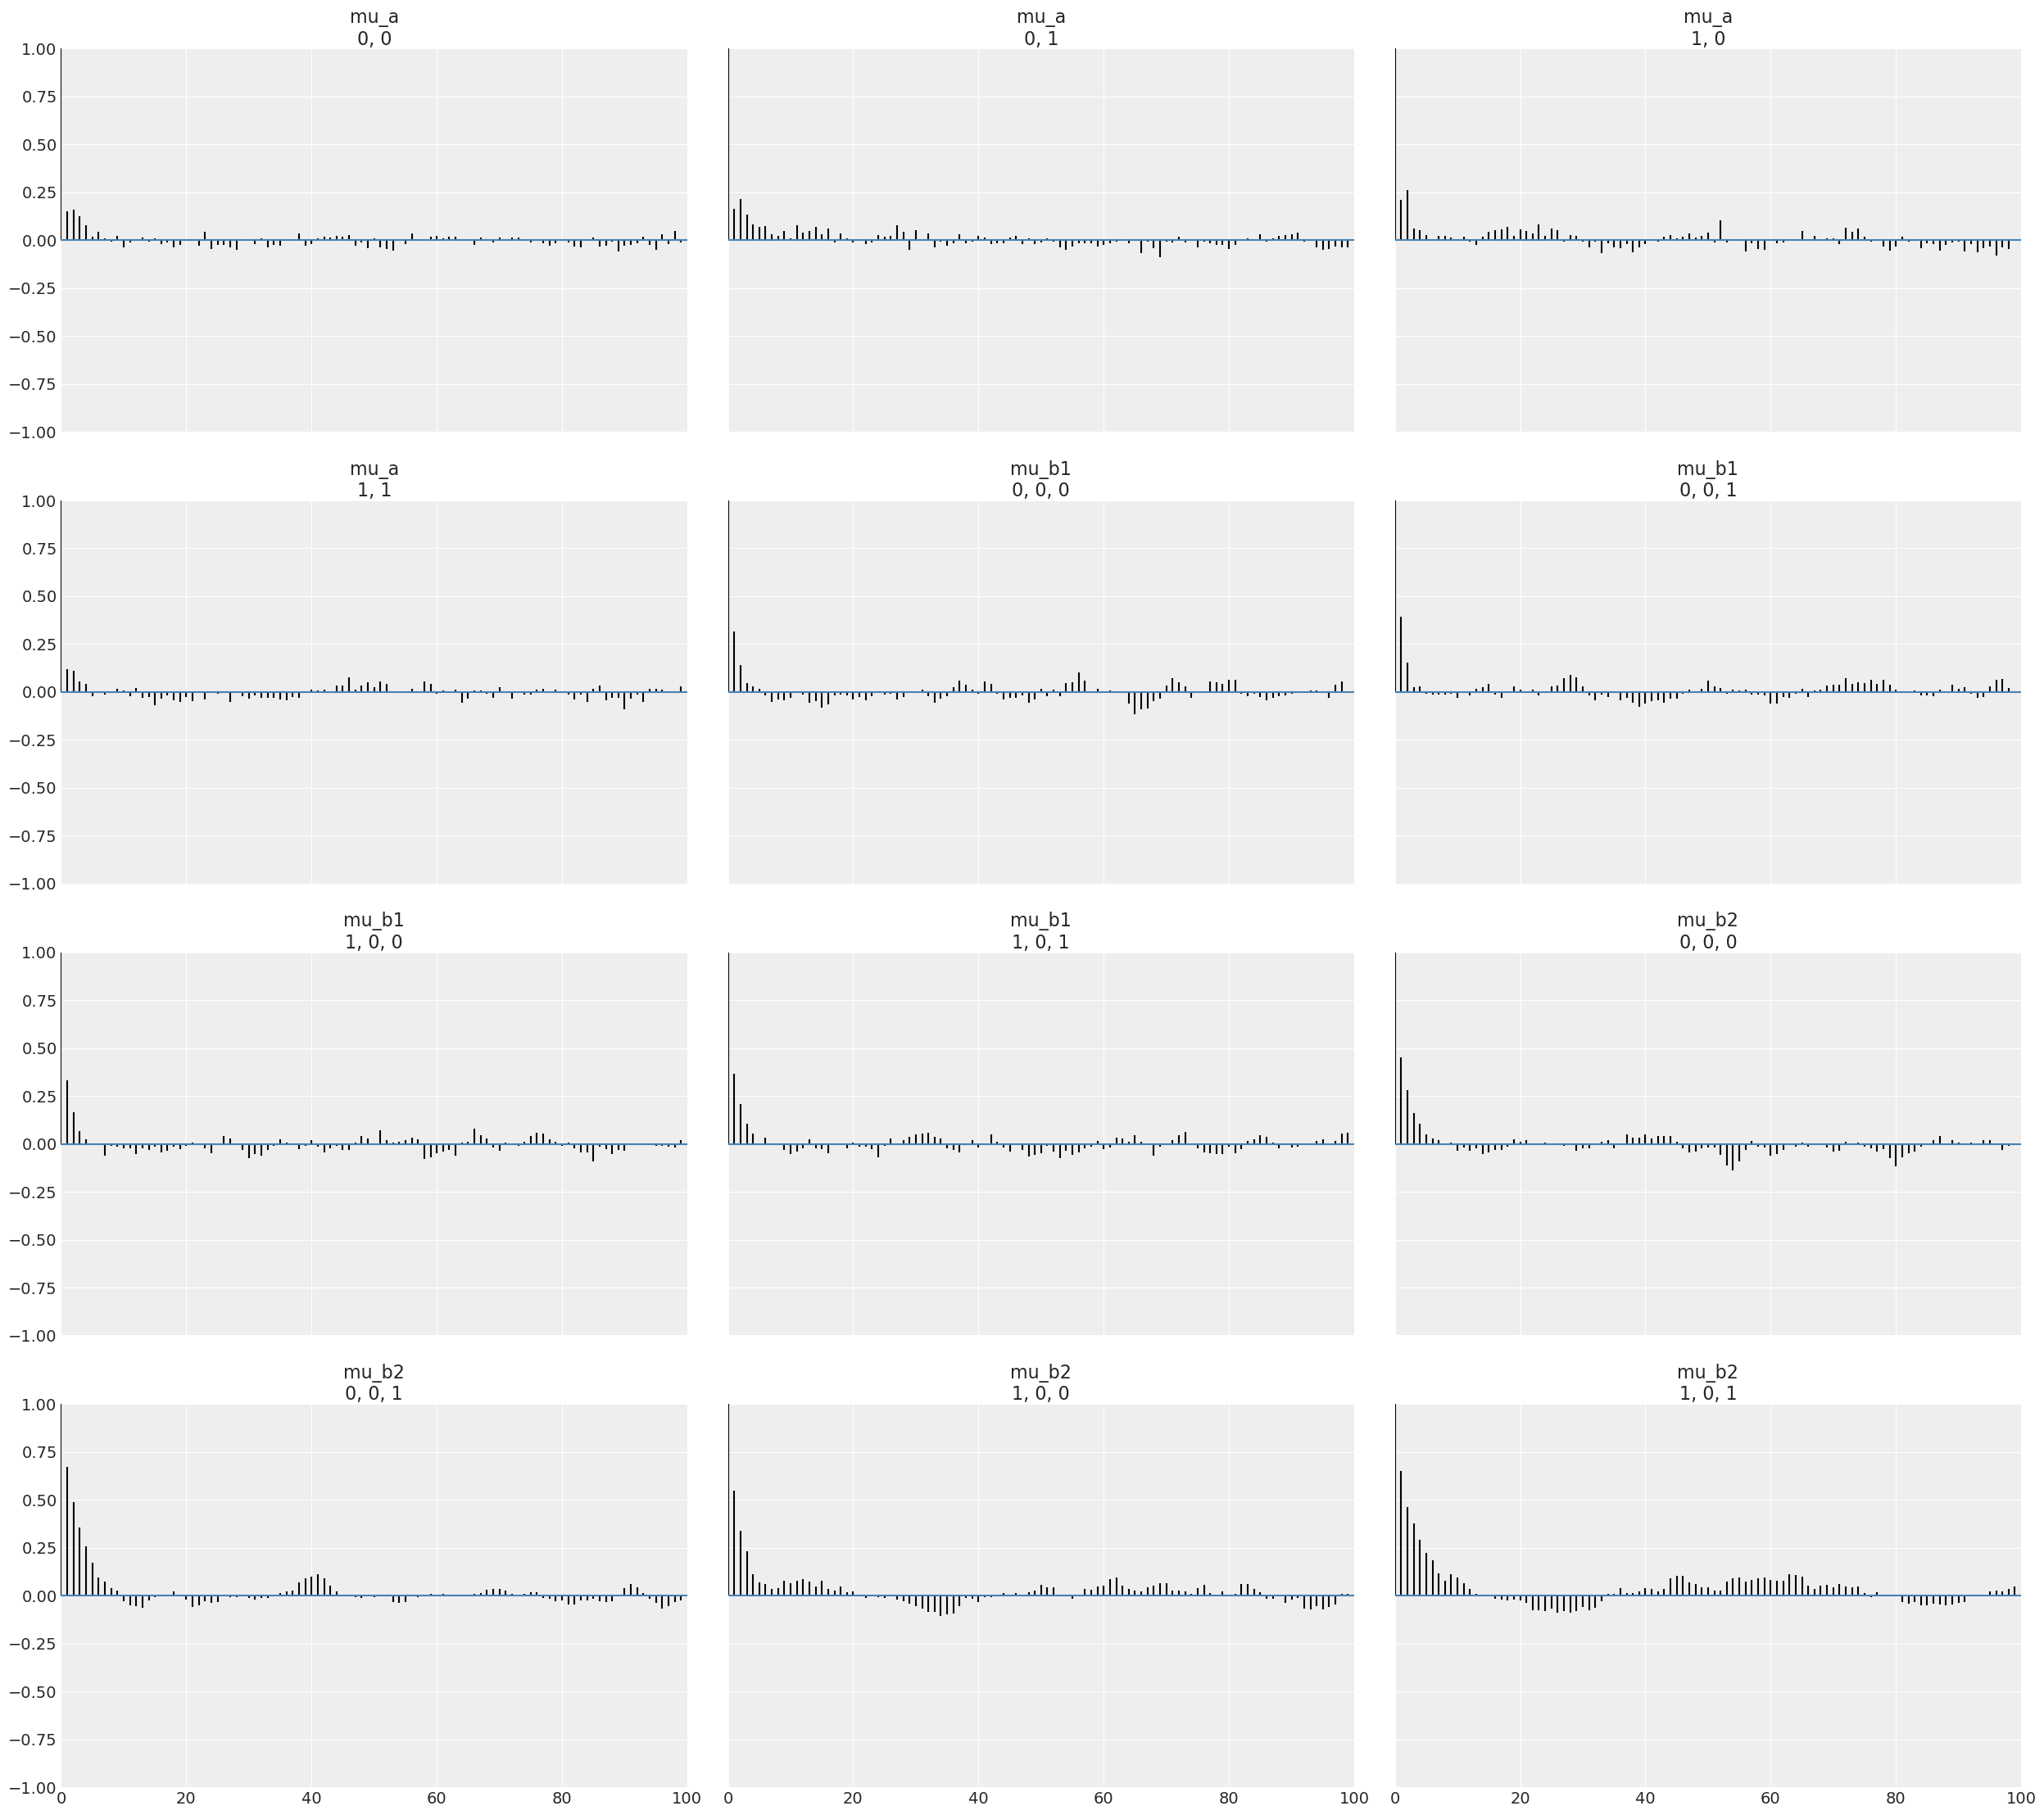

In [52]:
pm.autocorrplot(trace_hier, var_names=['mu_a', 'mu_b1', 'mu_b2'])